## Fully connected Neural Network

In this worksheet the california housing dataset will be analyzed and the price will be predicted using a fully connected neural network

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns 

### Data exploration

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/PyTorch/california_housing.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,SalePrice
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   SalePrice   20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,SalePrice
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

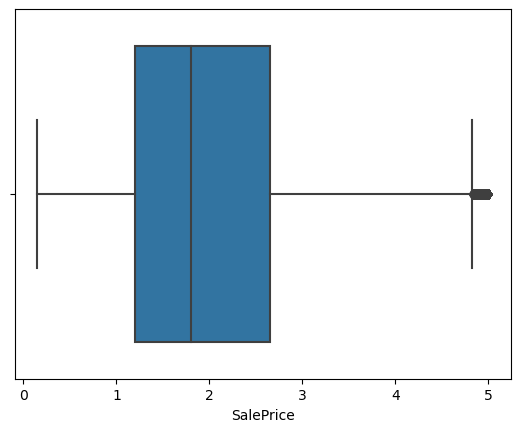

In [5]:
sns.boxplot(df["SalePrice"])

For this case we have to get rid of the outliers in the SalePrice that might affect the regression

In [6]:
filt = df["SalePrice"] > 5
df[filt]["SalePrice"].unique() # Only one price that might be not good for the model

array([5.00001])

In [7]:
df = df[~filt]

<AxesSubplot:>

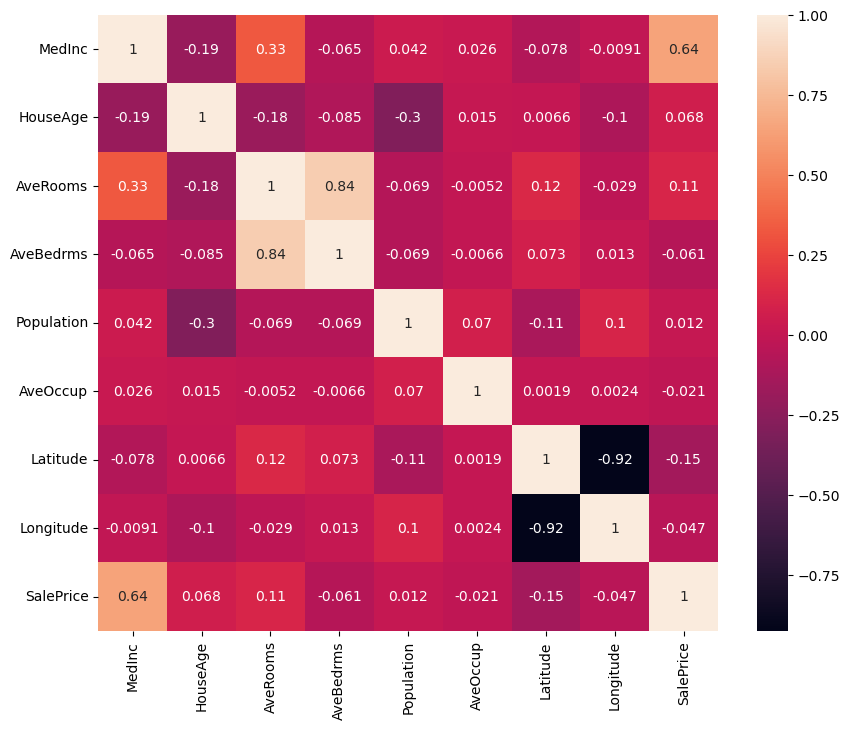

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

### DataLoader

In [9]:
class CustomDataLoader:
    def __init__(self, data, target, val_size=0.3, test_size=0.2, batch_size=64):  
        self.batch_size = batch_size
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(data.values, target.values, test_size=val_size, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_val, self.y_val, test_size=test_size, random_state=42)

        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_val = self.scaler.transform(self.X_val)
        self.X_test = self.scaler.transform(self.X_test)

    def get_data_loaders(self):
        train_dataset = TensorDataset(torch.tensor(self.X_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(self.X_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(self.X_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))
        
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader



X = df.drop(columns="SalePrice")
y = df["SalePrice"]
custom_loader = CustomDataLoader(X, y)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

### Model

In [10]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes):
        super().__init__()
        layers = []
        # Adding input layer to the first hidden layer
        layers.append(nn.Linear(in_features, hidden_layer_sizes[0]))
        layers.append(nn.ReLU())  # Adding ReLU activation function
        # Adding hidden layers
        for i in range(len(hidden_layer_sizes) - 1):
            layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
            layers.append(nn.ReLU())  # Adding ReLU activation function
        # Adding output layer
        layers.append(nn.Linear(hidden_layer_sizes[-1], out_features))
        
        # Combining all layers into a Sequential module
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)



# Define input and output sizes
in_features = X.shape[1]  
out_features = 1 

# Define list of hidden layer sizes
hidden_layer_sizes = [64, 32, 16]  

# Instantiate the model
model = Model(in_features, out_features, hidden_layer_sizes)

# Print the model architecture
print(model)

Model(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


### Loss Function and Optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Traning the model

Epoch 1/200, Train Loss: 1.2860, Test Loss: 0.4814
Epoch 2/200, Train Loss: 0.4080, Test Loss: 0.3742
Epoch 3/200, Train Loss: 0.3435, Test Loss: 0.3433
Epoch 4/200, Train Loss: 0.3226, Test Loss: 0.3267
Epoch 5/200, Train Loss: 0.3089, Test Loss: 0.3244
Epoch 6/200, Train Loss: 0.3002, Test Loss: 0.3100
Epoch 7/200, Train Loss: 0.2950, Test Loss: 0.2972
Epoch 8/200, Train Loss: 0.2878, Test Loss: 0.2994
Epoch 9/200, Train Loss: 0.2823, Test Loss: 0.2928
Epoch 10/200, Train Loss: 0.2762, Test Loss: 0.2823
Epoch 11/200, Train Loss: 0.2697, Test Loss: 0.2760
Epoch 12/200, Train Loss: 0.2683, Test Loss: 0.2781
Epoch 13/200, Train Loss: 0.2602, Test Loss: 0.2794
Epoch 14/200, Train Loss: 0.2581, Test Loss: 0.2658
Epoch 15/200, Train Loss: 0.2548, Test Loss: 0.2589
Epoch 16/200, Train Loss: 0.2509, Test Loss: 0.2617
Epoch 17/200, Train Loss: 0.2485, Test Loss: 0.2564
Epoch 18/200, Train Loss: 0.2455, Test Loss: 0.2569
Epoch 19/200, Train Loss: 0.2470, Test Loss: 0.2549
Epoch 20/200, Train L

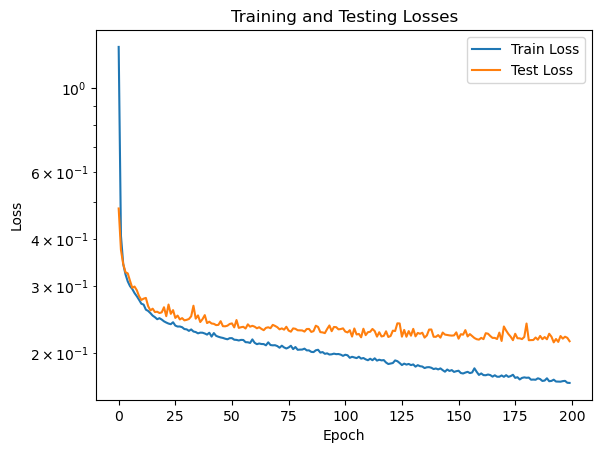

0.76677565045209

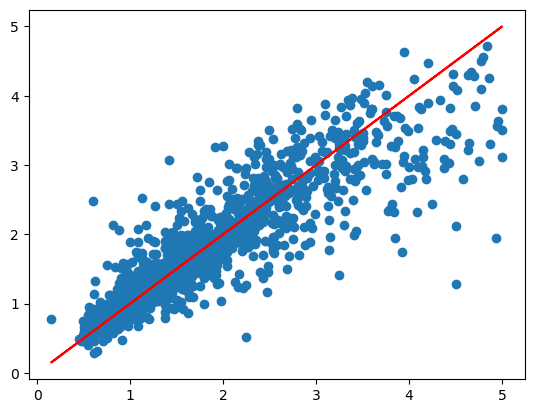

In [12]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            test_preds = []
            test_targets = []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                test_preds.extend(outputs.squeeze().tolist())
                test_targets.extend(labels.tolist())
        test_r2 = r2_score(test_targets, test_preds)
        plt.plot(test_targets, test_targets, color="red")
        plt.scatter(test_targets, test_preds)

        return test_r2
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(200)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)

In [13]:
# Predict a house sale price

x = df.iloc[1,:8].values

# Scale the input features using the scaler
x_scaled = custom_loader.scaler.transform(x.reshape(1, -1))  # Reshape to (1, -1) for single sample

# Convert the scaled array to a PyTorch tensor
x_tensor = torch.tensor(x_scaled, dtype=torch.float32)

# Pass the tensor through the model for prediction
prediction = model(x_tensor)

# Print the prediction
print(prediction)


tensor([[4.4144]], grad_fn=<AddmmBackward0>)
